In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


2023-10-05 23:15:43.996917: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 23:15:44.939774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-05 23:15:44.939814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-05 23:15:44.946396: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-05 23:15:45.583747: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-05 23:15:45.587951: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
from tensorflow.keras.datasets import mnist
from pyspark.sql.types import StructType,StructField, StringType, FloatType, ArrayType

In [3]:
import pandas as pd

In [4]:
# train, test load data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [5]:
# PY SPARK VERSION OF THE DATAFRAME
# def get_ps_dataFrame(x_data,y_data):
#     data_unified = [( x_data[i].tolist(), str(y_data[i])) for i in range(len(x_data))]
#     schema = StructType([ 
#         StructField("image",ArrayType(ArrayType(FloatType())),False), 
#         StructField("class", StringType(), False) 
#       ])
#     df = spark.createDataFrame(data=data_unified,schema=schema)
#     return df
# train_df = get_ps_dataFrame(x_train, y_train)

In [6]:
# print((df.count(), len(df.columns)))

In [7]:
def get_pd_dataFrame(x_data,y_data):
    return pd.DataFrame(data={'image':x_data.tolist(), 'class':y_data.tolist()})
train_df = get_pd_dataFrame(x_train, y_train)

In [8]:
def augment_data_cross_same_class_pair(df:pd.DataFrame):
    sorted_df = df.sort_values("class").reset_index(drop=True)
    shuffled_sorted_df = sorted_df.sample(frac=1).reset_index(drop=True).sort_values("class").reset_index(drop=True)
    shuffled_sorted_df.rename(columns={'image':'imagePair',"class": "classPair"}, inplace=True)
    result = pd.concat([sorted_df, shuffled_sorted_df], axis=1)
    return result[['image','imagePair', 'class']].sample(frac=1).reset_index(drop=True)

same_class_cross_df = augment_data_cross_same_class_pair(train_df)

In [12]:
import tensorflow as tf
def series_to_tensor(series):
    tensor_list = series.apply(lambda x: tf.constant(x))
    return tf.stack(tensor_list)
    
def prepare_train_traditional_autoencoder_data(train_df):
    image_tensor = series_to_tensor(train_df['image'])
    in_x_train = image_tensor
    out_x_train = image_tensor
    return [in_x_train, out_x_train]

def prepare_train_cross_same_class_autoencoder_data(train_df, additional_same_class_df):
    original_df =  train_df.copy()
    original_df["imagePair"] = original_df["image"]
    concat_df = pd.concat([original_df, additional_same_class_df])
    concat_df = concat_df.sample(frac=1).reset_index(drop=True)
    in_x_train = series_to_tensor(concat_df['image'])
    out_x_train = series_to_tensor(concat_df['imagePair'])
    return [in_x_train, out_x_train]

In [49]:
[trad_ae_x_in,  trad_ae_x_out]= prepare_train_traditional_autoencoder_data(train_df)

[cross_same_class_ae_x_in,  cross_same_class_ae_x_out]= prepare_train_cross_same_class_autoencoder_data(train_df, same_class_cross_df)



In [14]:
from keras import layers
class Autoencoder(keras.Model):
    def __init__(self, latent_dim, input_shape ):
        super(Autoencoder, self).__init__(input_shape,input_shape)
        self.latent_dim = latent_dim
        self.shape = input_shape
        self.encoder = tf.keras.Sequential([
            input_shape,
            layers.Conv2D(16, (3, 3), activation='relu'),
            layers.MaxPooling2D((2,2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2,2), padding='same'),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2,2), padding='same'),
        ])
        encoder_output_shape = self.encoder.layers[-1].output_shape
        self.decoder = tf.keras.Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=encoder_output_shape[1:]),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation='relu'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
        ])

    def call(self, inputs,training = False):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


input_shape = keras.Input(shape=(28, 28, 1))
latent_dim = 2
ae = Autoencoder(latent_dim, input_shape)
ae.compile(optimizer='adam', loss='mse')

In [15]:
ae.summary()

Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 4, 4, 8)           1904      
                                                                 
 sequential_3 (Sequential)   (None, 28, 28, 1)         2481      
                                                                 
Total params: 4385 (17.13 KB)
Trainable params: 4385 (17.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
# train autoencoder
from keras.callbacks import ModelCheckpoint

# specify the path where you want to save your models
checkpoint_file_path =  './checkpoints/ae'

# create a model checkpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_file_path, 
    monitor='val_loss',
    verbose=0, 
    save_weights_only=True, 
    save_best_only=False,
    mode='min', 
    save_freq="epoch")

history = ae.fit(trad_ae_x_in, trad_ae_x_in,
                epochs=10,#100
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[checkpoint] ,
                workers=8,
                use_multiprocessing=True)

Epoch 1/10
600/600 [==============================] - 19s 31ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 2/10
600/600 [==============================] - 18s 29ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
600/600 [==============================] - 17s 29ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
600/600 [==============================] - 17s 29ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
600/600 [==============================] - 17s 29ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
600/600 [==============================] - 18s 30ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
600/600 [==============================] - 18s 30ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
600/600 [==============================] - 18s 30ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
600/600 [==============================] - 18s 30ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
600/600 [==============================] - 18s 30ms/step - loss: 0.112

In [60]:

# LOAD SAVED MODEL FROM CHECK POINT
# ae.load_weights(checkpoint_file_path)

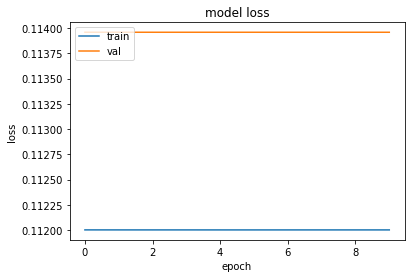

In [61]:
# plot loss ae
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import f1_score

def calculate_embed_vectors(model,x_data):
    #run encoder to get embeded vector in latent space     
    result = model.encoder.predict(x_data)
    #flat array into 1d array (vector)     
    return np.array(list(map(lambda x: x.flatten(), result)))

def calculate_centroids(vectors, y_data):
    classes = np.unique(y_data)
    class_vectors = {}
    for img_class in classes:
        class_vectors[img_class] = np.mean(vectors[np.where(y_data == img_class)], axis=0)        
    return class_vectors

def get_estimated_class(model, x_data, y_data):
    vectors = calculate_embed_vectors(model,x_data)
    class_centroids = calculate_centroids(vectors, y_data)
    classes = np.array(list(class_centroids.keys()))
    centroids = np.array(list(class_centroids.values()))
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(centroids,classes)
    return knn.predict(vectors)

def calculate_rand_index(model, x_data, y_data):
    labels_pred = get_estimated_class(model, x_data, y_data)
    return {
        'rand_score':rand_score(y_data,labels_pred),
        'f1_score':f1_score(y_data,labels_pred,average='macro')
           } 
    
calculate_rand_index(ae, x_test, y_test)    

313/313 [==============================] - 1s 2ms/step


{'rand_score': 0.8733427542754275, 'f1_score': 0.565182956738704}

In [63]:
scae = Autoencoder(latent_dim, input_shape)
scae.compile(optimizer='adam', loss='mse')

In [64]:
# train autoencoder
from keras.callbacks import ModelCheckpoint

# specify the path where you want to save your models
checkpoint_sc_file_path =  './checkpoints/scae'

# create a model checkpoint callback
checkpoint = ModelCheckpoint(
    checkpoint_sc_file_path, 
    monitor='val_loss',
    verbose=0, 
    save_weights_only=True, 
    save_best_only=False,
    mode='min', 
    save_freq="epoch")

history = scae.fit(cross_same_class_ae_x_in, cross_same_class_ae_x_out,
                epochs=10,#100
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[checkpoint] ,
                workers=8,
                use_multiprocessing=True)

Epoch 1/10
1200/1200 [==============================] - 34s 28ms/step - loss: 0.1131 - val_loss: 0.1140
Epoch 2/10
1200/1200 [==============================] - 33s 28ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/10
1200/1200 [==============================] - 33s 28ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/10
1200/1200 [==============================] - 33s 28ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/10
1200/1200 [==============================] - 33s 28ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 6/10
1200/1200 [==============================] - 33s 28ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 7/10
1200/1200 [==============================] - 33s 27ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 8/10
1200/1200 [==============================] - 34s 28ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 9/10
1200/1200 [==============================] - 33s 28ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 10/10
1200/1200 [==============================] - 33s 28m

In [65]:
calculate_rand_index(scae, x_test, y_test)    

313/313 [==============================] - 1s 2ms/step


{'rand_score': 0.8766336833683368, 'f1_score': 0.6074735790267998}

In [18]:
# prepare data aumentated for same class match
# train SCAE 
# plot loss SCAE

In [97]:
# calculate encoded_vector_ae using autoencoder
# calculate encoded_vector_vae using Variational autoencoder

In [99]:
# create function to calculate metric topK class metric
# calculateMetric(encoded_vector_ae)
# calculateMetric(encoded_vector_vae)

In [100]:
# data visualisation metrics

In [101]:
# discuss results

In [ ]:
# if there is time, apply in another dataset